# Energy Consumption | Time Series Forecasting


Data: A time series containing weekly information for electricity consumption in the East Region of the United States
<a href="https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption"> Source: PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States </a>

<h2> Steps: </h2>

1) Statistical analyses on time series data using Python

Checking for stationarity, unit root, seasonality, trend and autocorrelation



### <font color='CornflowerBlue'>1 - <ins> Importing libraries</ins>: <font color='violet'></font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews

sns.set_palette("colorblind")

In [2]:
from pandas.plotting import register_matplotlib_converters #Seasonal-Trend decomposition using LOESS (STL)

In [3]:
df = pd.read_csv("PJME_hourly.csv")


### <font color='CornflowerBlue'>2- <ins> EDA </ins>: <font color='violet'></font>

In [4]:
df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df.shape

(145366, 2)

In [6]:
for col in df:
    print(sum(pd.isnull(df[col])))

0
0


In [7]:
df.columns = df.columns.str.lower()
df.dtypes

datetime     object
pjme_mw     float64
dtype: object

In [8]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

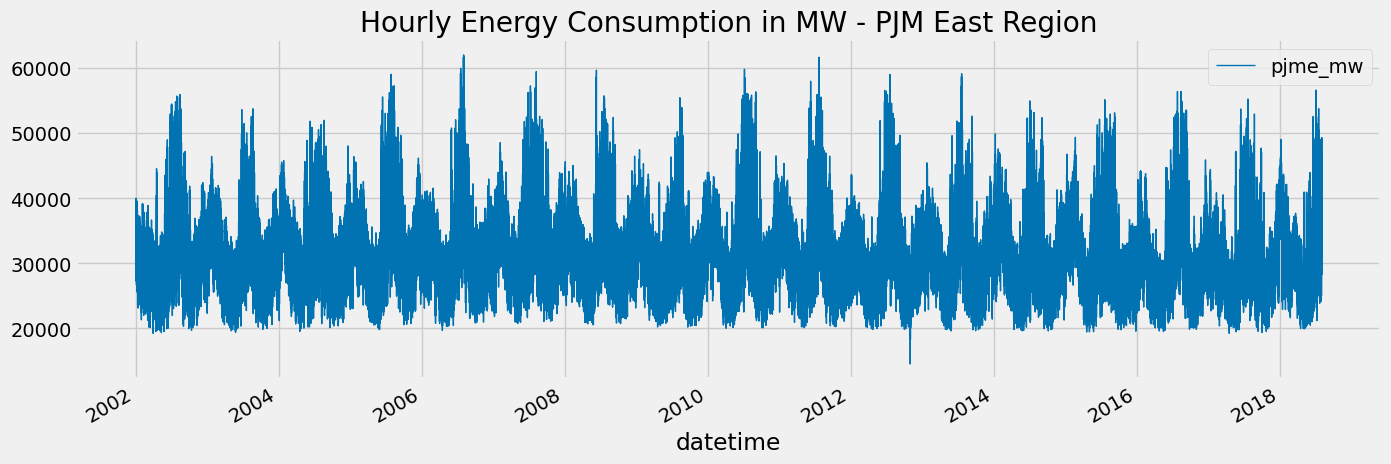

In [9]:
df.plot(figsize= (15,5),
        linewidth=1,
        title='Hourly Energy Consumption in MW - PJM East Region')
plt.savefig('plots/hourly_energy_consumption.png', dpi=300, bbox_inches='tight')       
plt.show()

## <center><font color='CornflowerBlue'>3-<ins> Checking for Stationarity <font color='CornflowerBlue'><ins><center>

 ### <font color='CornflowerBlue'>A-<ins> Checking for Stationarity with Augmented Dickey-Fuller test (ADF) <font color='CornflowerBlue'>


Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.828913
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [12]:
# ADF test
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [13]:
adf_test(X)

Results of Dickey-Fuller Test:


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

 ### <font color='CornflowerBlue'>B- </ins> Checking for Stationarity with Kwiatkowski-Phillips-Schmidt-Shin test for stationarity (KPSS) </ins>: <font color='violet'></font>


In [ ]:
from statsmodels.tsa.stattools import kpss

Null hypothesis (H0): that the process is trend stationary

Alternate hypothesis(H1): the series has a unit root (series is not stationary).

In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
kpss_test(df)

Results of KPSS Test:
Test Statistic             1.176234
p-value                    0.010000
Lags Used                162.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [ ]:
kpss(np.random.choice(range(-1000,1000),10000))

(0.03740890597065095,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
kpss(X, regression='c', nlags='auto', store=False)

(1.1762342370829708,
 0.01,
 162,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Conclusion: ADF does not find a unit root; but KPSS claims that it is non-stationary. Then, the series is difference stationary. 

(at least one of the tests claims to have found non-stationarity, differencing must be used.)

## <center><font color='CornflowerBlue'>4-<ins> Checking for Seasonality & Trend <font color='CornflowerBlue'><ins><center>

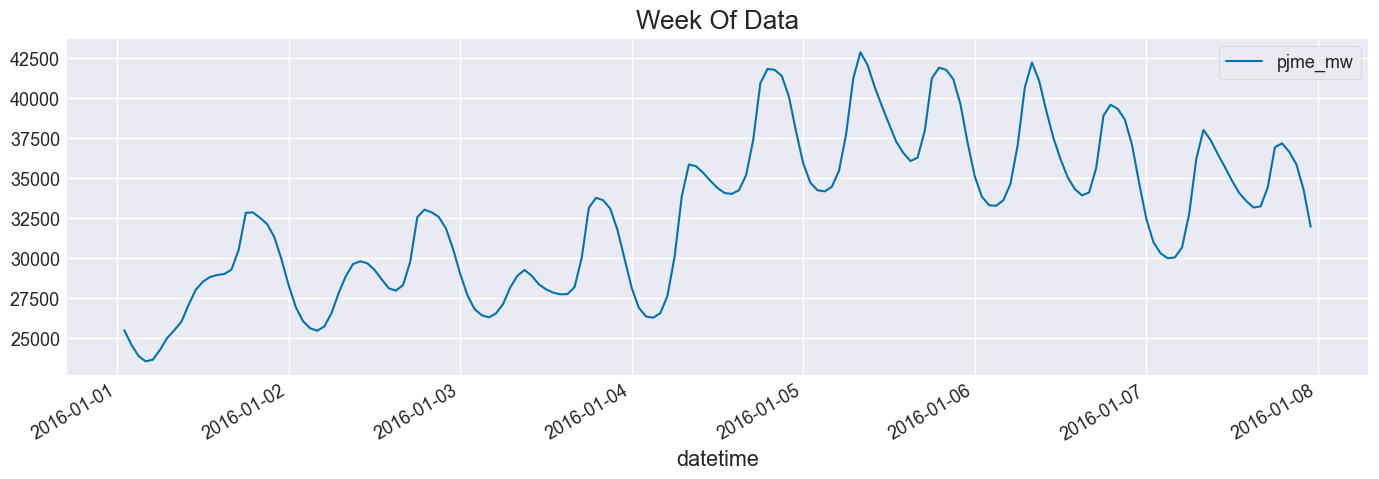

In [ ]:
df.loc[(df.index > '01-01-2016') & (df.index < '01-08-2016')] \
    .plot(figsize=(15, 5), title='Week Of Data', linewidth=1.5)

plt.show()

 ### <font color='CornflowerBlue'>B- </ins> Seasonal-Trend decomposition using LOESS (STL) </ins>: <font color='violet'></font> 

a) STL Decomposition plot

In [ ]:
#from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

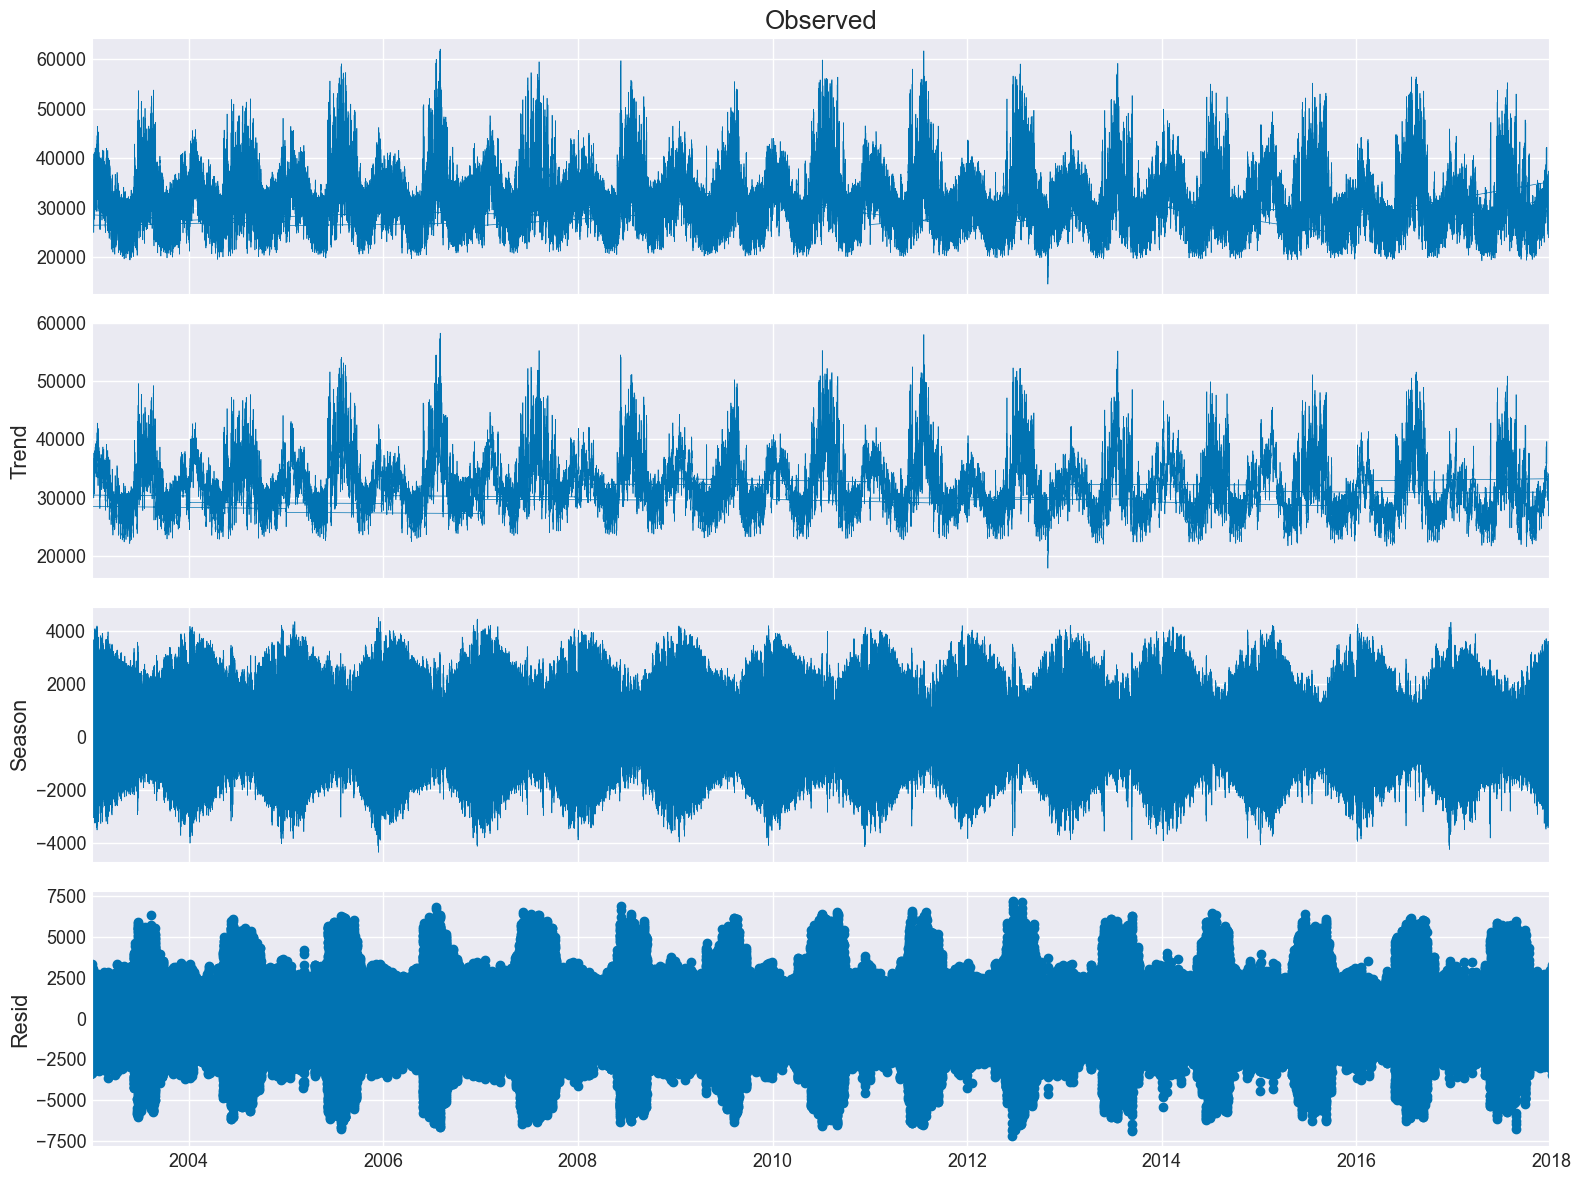

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

res = STL(df, period=12).fit()
fig = res.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(0.5)  
plt.savefig('plots/STL.png', dpi=300, bbox_inches='tight')
plt.show()

b) Mandall-Kendall trend Test

Hypotheses:
Null Hypothesis (H0): There is no trend in the time series.

Alternative Hypothesis (H1): There is a trend (either increasing or decreasing) in the time series

Positive Z-Score: Indicates an increasing trend.
Negative Z-Score: Indicates a decreasing trend.
P-Value: Determines the significance level of the trend. A low p-value (typically < 0.05) rejects the null hypothesis, indicating a significant trend.

In [ ]:
from scipy.stats import kendalltau

# Sample time series data
data = df['pjme_mw']

# Perform the Mann-Kendall trend test
tau, p_value = kendalltau(data.index, data)

print(f"Kendall's tau: {tau}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant trend in the time series.")
else:
    print("No significant trend detected in the time series.")

Kendall's tau: -0.04791052695148664
P-value: 2.801793697350987e-165
There is a significant trend in the time series.


## <center><font color='CornflowerBlue'>5-<ins> Checking for Autocorrelation <font color='CornflowerBlue'><ins><center>

a) Autocorrelation Fonction Plot

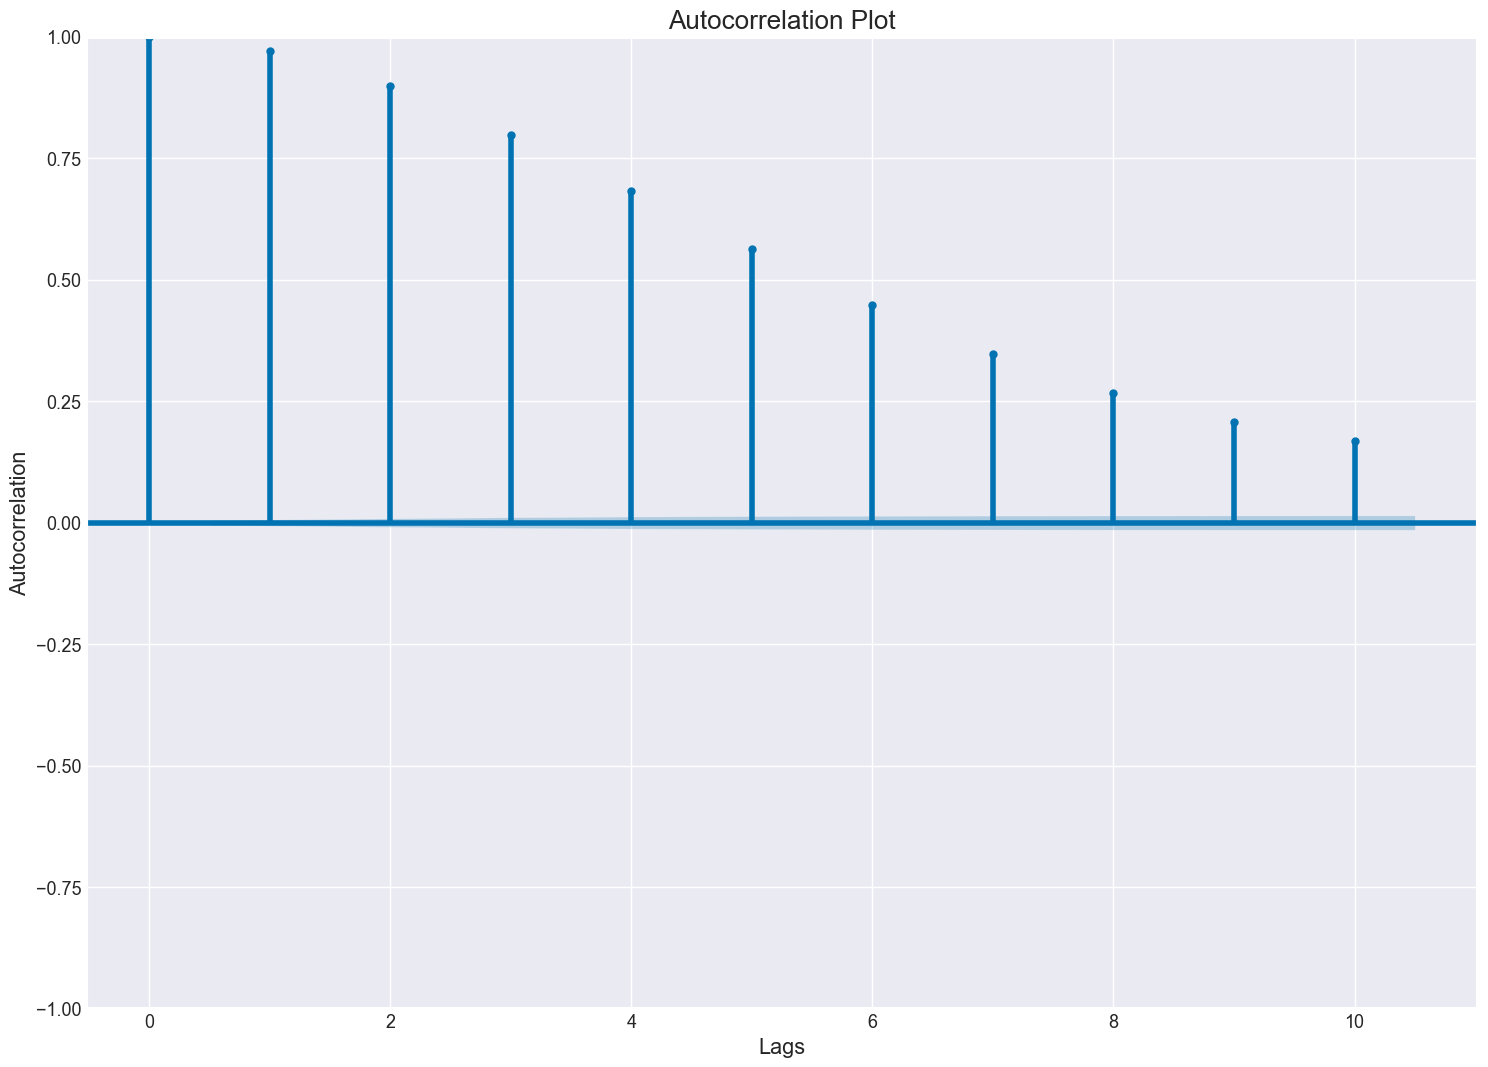

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming df is a single column DataFrame or Series
plot_acf(df, lags=10)
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()



b) Partial Correlation Fonction Plot

c) Durbin - Watson Statistic

## <center><font color='CornflowerBlue'>5-<ins> Feature Creation <font color='CornflowerBlue'><ins><center>

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2 = create_features(df)


In [ ]:
df.columns

Index(['pjme_mw'], dtype='object')

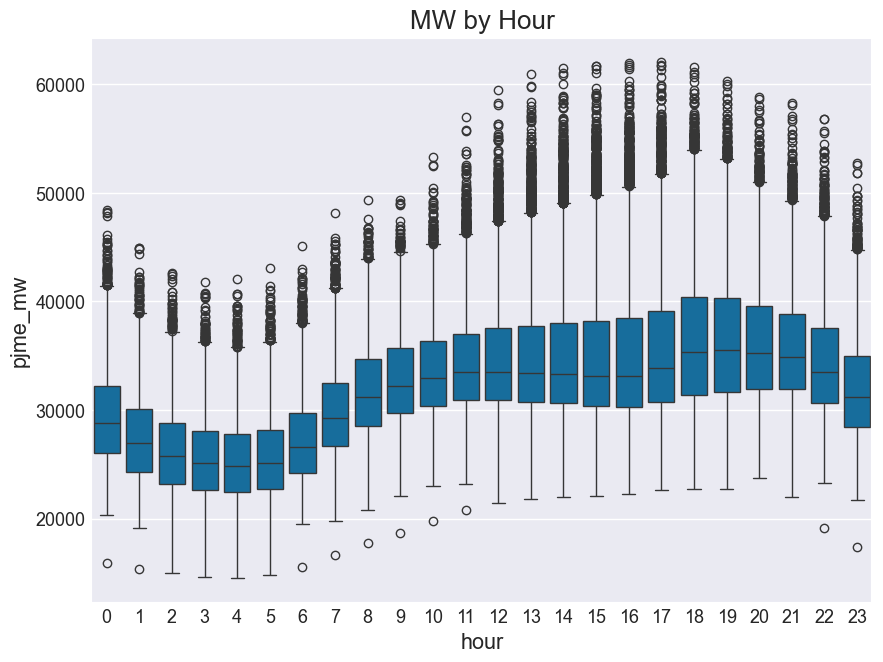

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.boxplot(data=df2, x='hour', y='pjme_mw')
ax.set_title('MW by Hour')
plt.savefig('plots/mw_hour.png', dpi=300, bbox_inches='tight')


plt.show()

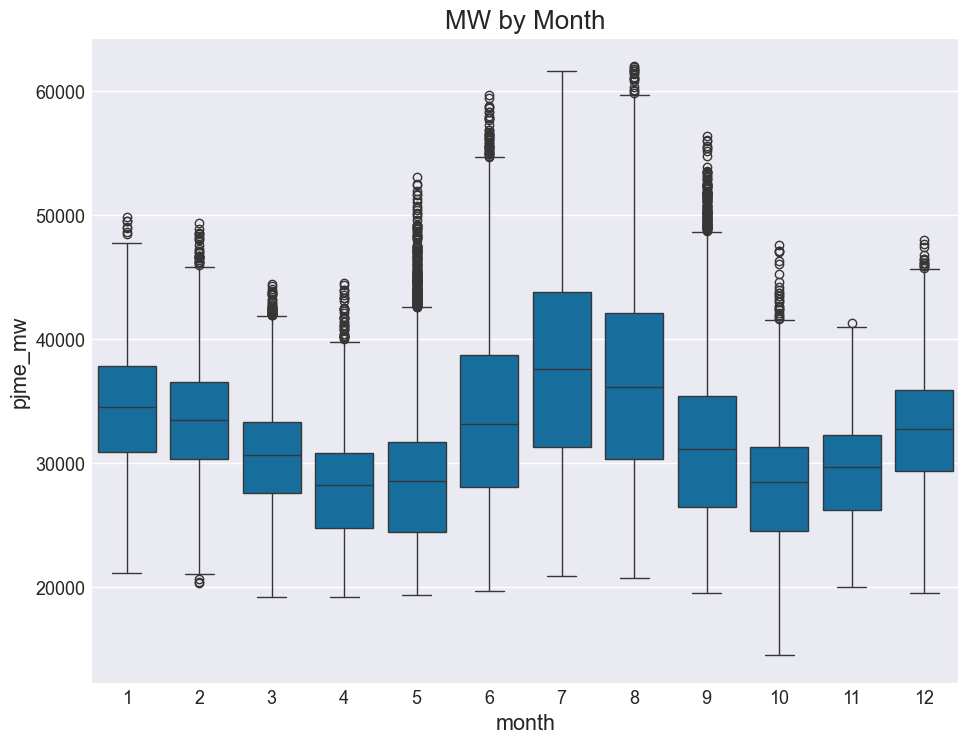

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='month', y='pjme_mw')
ax.set_title('MW by Month')
plt.savefig('plots/mw_month.png', dpi=300, bbox_inches='tight')

plt.show()

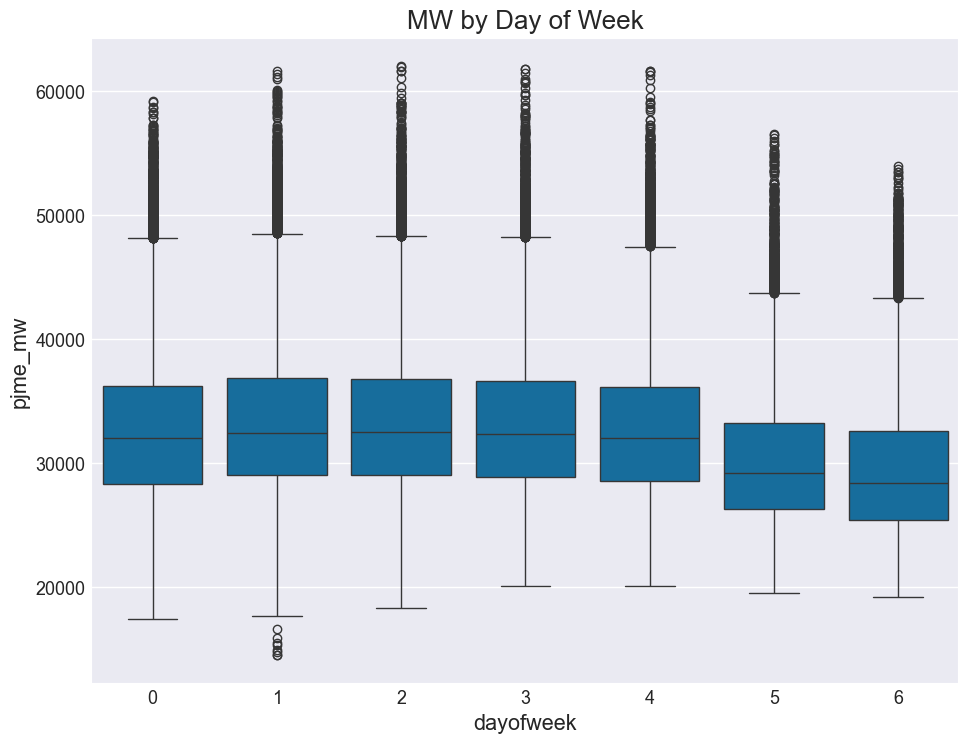

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='dayofweek', y='pjme_mw')
ax.set_title('MW by Day of Week')
plt.savefig('plots/mw_day_week.png', dpi=300, bbox_inches='tight')

plt.show()

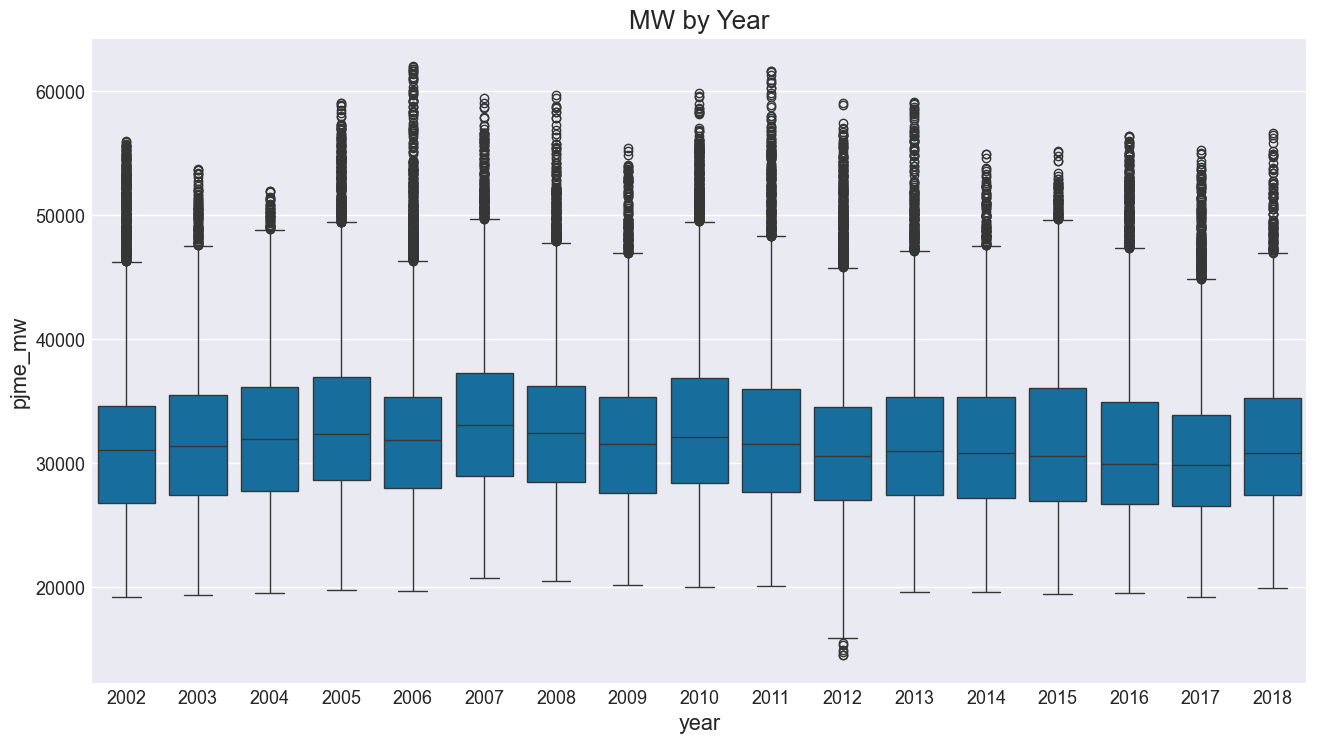

In [ ]:

fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df2, x='year', y='pjme_mw',  dodge=False, legend=False) 
ax.set_title('MW by Year')
plt.savefig('plots/mw_year.png', dpi=300, bbox_inches='tight')

plt.show()



## <center><font color='CornflowerBlue'>6-<ins>Data Split <font color='CornflowerBlue'><ins><center>

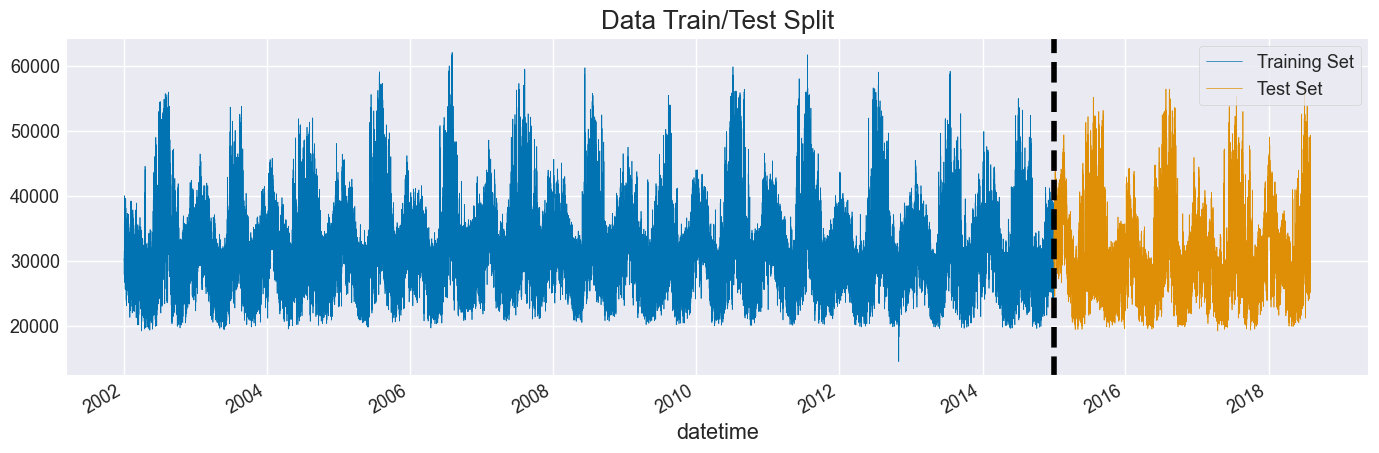

In [ ]:

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', linewidth=0.5)  # Set linewidth for training set
test.plot(ax=ax, label='Test Set', linewidth=0.5)  # Set linewidth for test set
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.savefig('plots/train_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'pjme_mw'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\rober\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:160: UserWarning: [21:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

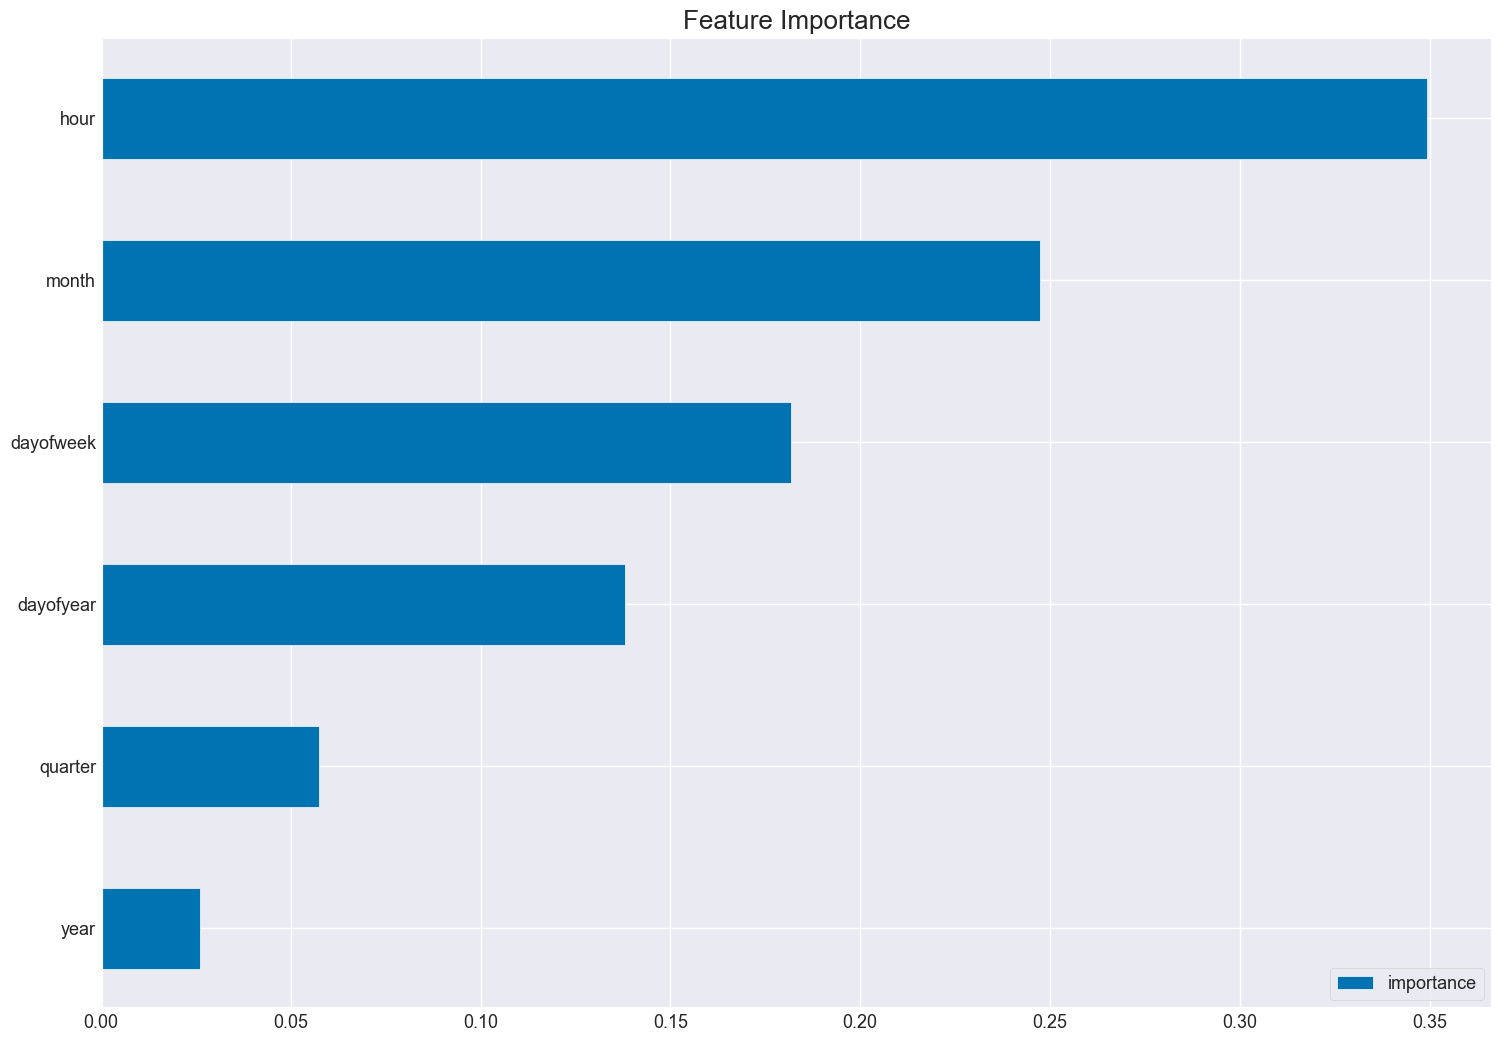

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()